# 短期记忆总结

In [2]:
! pip install langgraph langchain_core langchain_openai python-dotenv langgraph-checkpoint-redis


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 裁剪消息

In [3]:
from langchain_core.messages.utils import trim_messages, count_tokens_approximately

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver

import os

model = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    base_url=os.getenv("OPENAI_BASE_URL"),
    model=os.getenv("MODEL_NAME"),
)
summarization_model = model.bind(max_tokens=128)


def call_model(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=128,
        # max_tokens=1280, # 修改token长度试试
        start_on="human",
        end_on=("human", "tool"),
    )
    response = model.invoke(messages)
    return {"messages": [response]}


checkpointer = InMemorySaver()
builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_edge(START, "call_model")
graph = builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": "hi, my name is bob"}, config)
graph.invoke({"messages": "write a short poem about cats"}, config)
graph.invoke({"messages": "now do the same but for dogs"}, config)
final_response = graph.invoke({"messages": "what's my name?"}, config)

# 已经获取不到最后消息了，因为裁减了
final_response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You haven’t told me your name yet—at least, not in any of our exchanges so far. I don’t retain memory between conversations once you close the chat window, so I’d need you to share it again.


## 删除消息

当超过2条消息的时候，删除最开始的两条消息

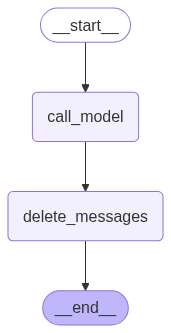

111 [('human', "hi! I'm bob")]
111 [('human', "hi! I'm bob"), ('ai', 'Hi Bob! Nice to meet you—what can I help you with today?')]
222 [('human', "hi! I'm bob"), ('ai', 'Hi Bob! Nice to meet you—what can I help you with today?'), ('human', "what's my name?")]
222 [('human', "hi! I'm bob"), ('ai', 'Hi Bob! Nice to meet you—what can I help you with today?'), ('human', "what's my name?"), ('ai', 'Your name is Bob!')]
222 [('human', "what's my name?"), ('ai', 'Your name is Bob!')]


In [4]:
from langchain_core.messages import RemoveMessage
from IPython.display import Image, display

def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 2:
        # remove the earliest two messages
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}

def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

builder = StateGraph(MessagesState)
# 使用add_sequence串联节点
builder.add_sequence([call_model, delete_messages])
builder.add_edge(START, "call_model")

checkpointer = InMemorySaver()
app = builder.compile(checkpointer=checkpointer)

display(Image(app.get_graph().draw_mermaid_png()))

for event in app.stream(
    {"messages": [{"role": "user", "content": "hi! I'm bob"}]},
    config,
    stream_mode="values"
):
    print(111, [(message.type, message.content) for message in event["messages"]])

for event in app.stream(
    {"messages": [{"role": "user", "content": "what's my name?"}]},
    config,
    stream_mode="values"
):
    print(222, [(message.type, message.content) for message in event["messages"]])

## 总结记忆

使用大模型来总结历史记录
- 使用SummarizationNode来生成节点总结历史记录

In [5]:
! pip install langmem


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# from typing import Any, TypedDict

# from langchain_core.messages import AnyMessage
# from langchain_core.messages.utils import count_tokens_approximately
# from langgraph.graph import StateGraph, START, MessagesState
# from langgraph.checkpoint.memory import InMemorySaver
# from langmem.short_term import SummarizationNode, RunningSummary

# summarization_model = model.bind(max_tokens=128)

# class State(MessagesState):
#     context: dict[str, RunningSummary]  

# class LLMInputState(TypedDict):  
#     summarized_messages: list[AnyMessage]
#     context: dict[str, RunningSummary]

# summarization_node = SummarizationNode(
#     token_counter=count_tokens_approximately,
#     model=summarization_model,
#     max_tokens=2560,
#     max_tokens_before_summary=256,
#     max_summary_tokens=1280,
# )

# def call_model(state: LLMInputState):  
#     response = model.invoke(state["summarized_messages"])
#     return {"messages": [response]}

# checkpointer = InMemorySaver()
# builder = StateGraph(State)
# builder.add_node(call_model)
# builder.add_node("summarize", summarization_node)
# builder.add_edge(START, "summarize")
# builder.add_edge("summarize", "call_model")

from langchain_core.messages import AnyMessage
from langchain_core.messages.utils import count_tokens_approximately
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver
from langmem.short_term import SummarizationNode, RunningSummary

# 正确的状态定义
class State(MessagesState):
    context: dict[str, RunningSummary]
    summarized_messages: list[AnyMessage] = []  # 添加这个字段

summarization_model = model.bind(max_tokens=128)

summarization_node = SummarizationNode(
    token_counter=count_tokens_approximately,
    model=summarization_model,
    max_tokens=2560,
    max_tokens_before_summary=256,
    max_summary_tokens=1280,
)

# 修正后的call_model函数
def call_model(state: State):  # 使用正确的状态类型
    # 使用SummarizationNode处理后的消息
    messages = state.get("summarized_messages", state["messages"])
    response = model.invoke(messages)
    return {"messages": [response]}

checkpointer = InMemorySaver()
builder = StateGraph(State)
builder.add_node("call_model", call_model)  # 注意节点名称
builder.add_node("summarize", summarization_node)
builder.add_edge(START, "summarize")
builder.add_edge("summarize", "call_model")
graph = builder.compile(checkpointer=checkpointer)

graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": "hi, my name is bob"}, config)
graph.invoke({"messages": "write a short poem about cats"}, config)
graph.invoke({"messages": "now do the same but for dogs"}, config)
final_response = graph.invoke({"messages": "what's my name?"}, config)

final_response["messages"][-1].pretty_print()
print("\nSummary:", final_response["context"]["running_summary"].summary)

================================== Ai Message ==================================

Your name is Bob.

Summary: Bob greeted the assistant, which responded in kind. Bob then asked for a short poem about cats, received one, requested a similar poem for dogs, and got it.
